<a href="https://colab.research.google.com/github/ASR16arif/Machine-Learning/blob/main/Pneumonia_Detection_from_X-ray_image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing the dataset

In [1]:
!pip install kaggle

In [2]:
from google.colab import files

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"asrarif","key":"27d77ccdec77a7550640742bf46f9aeb"}'}

In [4]:
! mkdir ~/.kaggle


In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:27<00:00, 111MB/s]
100% 2.29G/2.29G [00:27<00:00, 88.8MB/s]


In [9]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

Importing the Dependencies

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

from yellowbrick.model_selection import learning_curve


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.utils import shuffle as shf
import pickle
import os
import glob as gb

Data Collection and Analysis

In [11]:
code = {'NORMAL':0 ,'PNEUMONIA':1}
#function to return the class of the images from its number, so the function would return 'Normal' if given 0, and 'PNEUMONIA' if given 1.
def getcode(n) :
    for x , y in code.items() :
        if n == y :
            return x

In [12]:
#the directory that contain the train images set
trainpath='/content/chest_xray/train/'

X_train = []
y_train = []
for folder in  os.listdir(trainpath) :
    files = gb.glob(pathname= str( trainpath + folder + '/*.jpeg'))
    for file in files:
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_train.append(list(image_array))
        y_train.append(code[folder])
np.save('X_train',X_train)
np.save('y_train',y_train)

In [13]:
#the directory that contain the test images set
testpath='/content/chest_xray/test/'

X_test = []
y_test = []
for folder in  os.listdir(testpath) :
    files = gb.glob(pathname= str( testpath + folder + '/*.jpeg'))
    for file in files:
        image = cv2.imread(file)
        #resize images to 64 x 64 pixels
        image_array = cv2.resize(image , (64,64))
        X_test.append(list(image_array))
        y_test.append(code[folder])
np.save('X_test',X_test)
np.save('y_test',y_test)

In [14]:
#X_train, X_test contain the images as numpy arrays, while y_train, y_test contain the class of each image
loaded_X_train = np.load('./X_train.npy')
loaded_X_test = np.load('./X_test.npy')
loaded_y_train = np.load('./y_train.npy')
loaded_y_test = np.load('./y_test.npy')

In [15]:
print(loaded_X_train.shape)
#the shape return dimensions of X_train, we have 5216 images of 64 x 64 pixels.
#while the forth dimension stores the RGB information of each pixel

(5216, 64, 64, 3)


In [16]:
print(loaded_X_test.shape)

(624, 64, 64, 3)


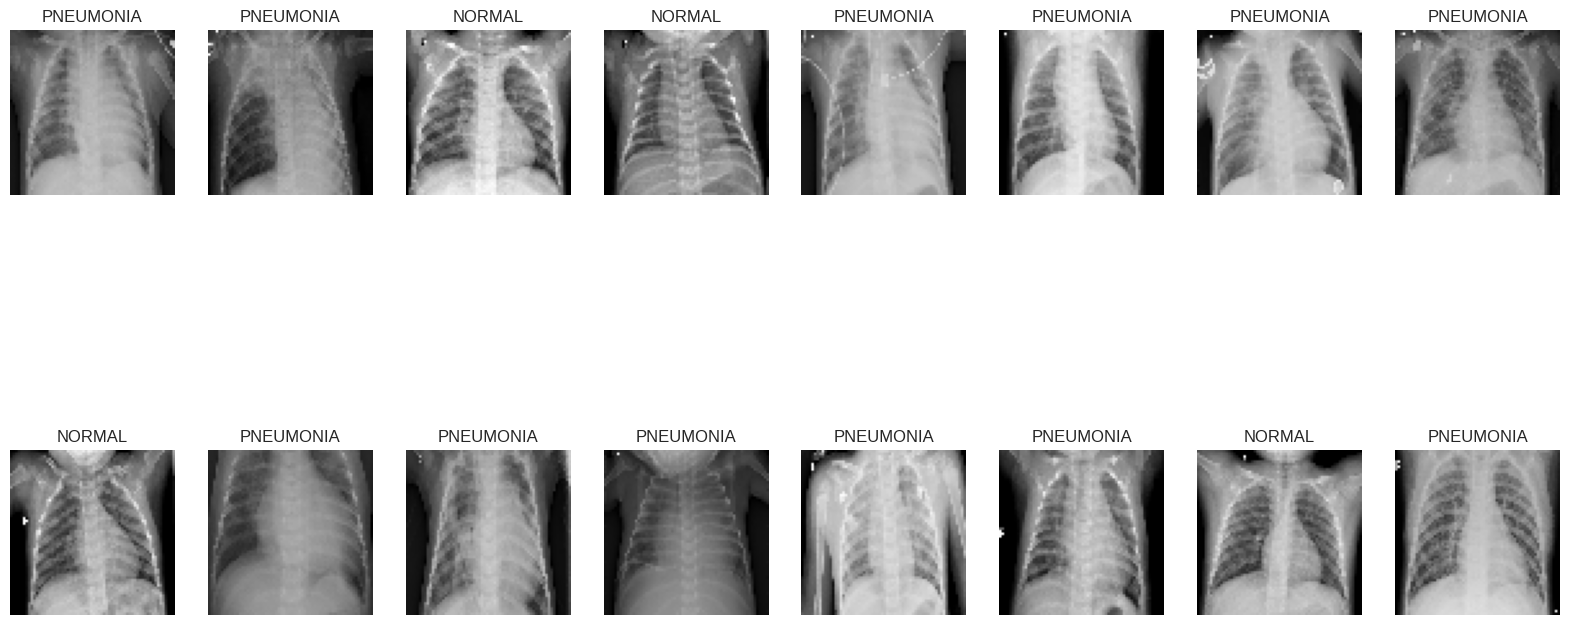

In [17]:
#plotting images of NORMAL and PNEUMONIA
plt.figure(figsize=(20,10))
for n , i in enumerate(np.random.randint(0,len(loaded_X_train),16)):
    plt.subplot(2,8,n+1)
    plt.imshow(loaded_X_train[i])
    plt.axis('off')
    plt.title(getcode(loaded_y_train[i]))

In [18]:
#function to plot the pixel intensity of each image.
def plotHistogram(a):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5)
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5)
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5)

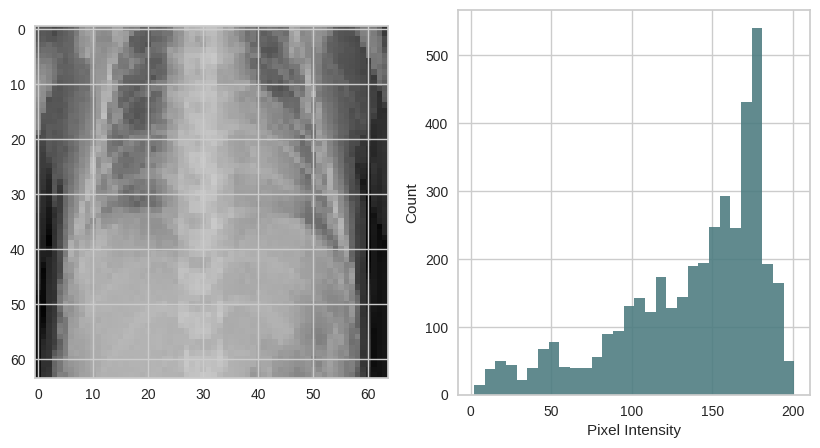

In [19]:
plotHistogram(loaded_X_train[np.random.randint(len(loaded_X_train))])

In [20]:
#flatten the images into a 2d array, for model training and testing
X_train = loaded_X_train.reshape([-1, np.product((64,64,3))])
X_test = loaded_X_test.reshape([-1, np.product((64,64,3))])

In [21]:
print(X_train.shape)
print(X_test.shape)

(5216, 12288)
(624, 12288)


In [22]:
y_train = loaded_y_train
y_test = loaded_y_test

In [23]:
#shuffle train and test data sets in a consistent way
X_train, y_train = shf(X_train, y_train, random_state=15)
X_test, y_test = shf(X_test, y_test, random_state=15)

In [24]:
#making an instance of each algorithm
knn = KNeighborsClassifier(n_neighbors=10)
log_reg  = LogisticRegression()
dtc  = DecisionTreeClassifier()
rfc = RandomForestClassifier()
svm = SVC()

In [25]:
#fitting each model using X_train and y_train
knn.fit(X_train, y_train)
log_reg.fit(X_train, y_train)
dtc.fit(X_train, y_train)
rfc.fit(X_train, y_train)
svm.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC()

In [26]:
#scoring each model
print('KNN accuracy score is: ' + str(knn.score(X_test, y_test)))
print('Logistic Regression accuracy score is: ' + str(log_reg.score(X_test, y_test)))
print('Decision Tree Classifier accuracy score is: ' + str(dtc.score(X_test, y_test)))
print('Random forests Classifier accuracy score is: ' + str(rfc.score(X_test, y_test)))
print('Support Vector Machine Classifier accuracy score is: ' + str(svm.score(X_test, y_test)))


KNN accuracy score is: 0.7339743589743589
Logistic Regression accuracy score is: 0.7419871794871795
Decision Tree Classifier accuracy score is: 0.7371794871794872
Random forests Classifier accuracy score is: 0.7740384615384616
Support Vector Machine Classifier accuracy score is: 0.7612179487179487


In [27]:
#making predictions for each model
knn_predcited = knn.predict(X_test)
log_reg_predcited = log_reg.predict(X_test)
dtc_predcited = dtc.predict(X_test)
rfc_predcited = rfc.predict(X_test)
svm_predcited = svm.predict(X_test)

In [28]:
X_train = X_train.reshape(-1, 64, 64, 3)
X_test = X_test.reshape(-1, 64, 64, 3)

In [35]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint



In [36]:
model = Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))

# Add a pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a fully connected layer with 128 neurons
model.add(Dense(128, activation='relu'))

# Add a dropout layer for regularization
model.add(Dropout(0.5))

# Add the output layer with a sigmoid activation function
model.add(Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [37]:
# Define the checkpoint filepath
checkpoint_filepath = '/path/to/checkpoint'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                             verbose=1)

In [39]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test),callbacks=[checkpoint])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 3.2193 - accuracy: 0.8738
Epoch 1: val_loss improved from inf to 0.65867, saving model to /path/to/checkpoint
163/163 [==============================] - 33s 192ms/step - loss: 3.2193 - accuracy: 0.8738 - val_loss: 0.6587 - val_accuracy: 0.7564
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 0.1583 - accuracy: 0.9444
Epoch 2: val_loss did not improve from 0.65867
163/163 [==============================] - 30s 183ms/step - loss: 0.1583 - accuracy: 0.9444 - val_loss: 0.9260 - val_accuracy: 0.7260
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9467
Epoch 3: val_loss did not improve from 0.65867
163/163 [==============================] - 30s 184ms/step - loss: 0.1421 - accuracy: 0.9467 - val_loss: 1.0539 - val_accuracy: 0.7292
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.9582
Epoch 4: val_loss did not improve fr